In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Fragments
from ClickReaction import BocRemoval
from ClickReaction import CuAAC
from rdkit.Chem import  Descriptors
from rdkit.Chem.Draw import IPythonConsole
import io
import itertools
from PIL import Image
from ClickReaction import BocRemoval
from tqdm import tqdm

In [4]:
def file_imput(file,selec):
    file_output = []
    with open(file, 'r') as f:
        lines = f.readlines()
        amine_smiles = [l.split(',')for l in lines]
    amine_smiles = amine_smiles[1:]
    if selec == 'yes':
        for i in range (len(amine_smiles)):
            if float(amine_smiles[i][-3]) > 0.0 and float(amine_smiles[i][-4]) > 0.0:
                pass
            else:
                file_output.append(amine_smiles[i][-10])
    else:
        for i in range (len(amine_smiles)):
            file_output.append(amine_smiles[i][-10])
    return file_output
# 文件输入，筛选掉同时有一个以上氨基和一个以上炔基的结构

In [5]:
def convert_primary_amines_to_diazonium(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    primary_amine_pattern = Chem.MolFromSmarts('[NX3;H2]')  
    diazonium_pattern = Chem.MolFromSmiles('[N]=[N+]=[N-]')  
    if molecule.HasSubstructMatch(primary_amine_pattern):
        modified_molecule = Chem.ReplaceSubstructs(molecule, primary_amine_pattern, diazonium_pattern, replaceAll=True)[0]
        new_smiles = Chem.MolToSmiles(modified_molecule, isomericSmiles=True)
        return new_smiles
    elif '[NH2+]' in smiles:
        try:
            boc_protected_amine = Chem.MolFromSmiles(smiles)
            reaction = BocRemoval(bocamine=boc_protected_amine)
            molecule = reaction.get_product()
            modified_molecule = Chem.ReplaceSubstructs(molecule, primary_amine_pattern, diazonium_pattern, replaceAll=True)[0]
            new_smiles = Chem.MolToSmiles(modified_molecule, isomericSmiles=True)
            return new_smiles
        except:
            # print(smiles,"无法脱Boc")
            return None
    else:
        # print( smiles,"未找到一级胺")
        return None

In [26]:
def convert_diazo_to_triaz( acetylene_smiles,amine_smiles,):
    rxn = Chem.ReactionFromSmarts('[*:6][C:1]#[C:2].[N-:3]=[N+:4]=[N:5]>>[N:5]1([C:2]=[C:1]([*:6])[N:3]=[N:4]1)')
    b = []
    try:
        product = rxn.RunReactants((Chem.MolFromSmiles(amine_smiles), Chem.MolFromSmiles(acetylene_smiles)))
        for i in range(len(product)):
            a=Chem.MolToSmiles(product[i][0])
            if '[N+]=[N-]' in a :
                a = a.replace('[N+]=[N-]','N=N')
            elif '[N-]=[N+]' in a:
                a=a.replace('[N-]=[N+]','N=N')
            b.append(a)
        return b
    except:
        # print(amine_smiles,acetylene_smiles,"未找到反应产物")
        return None

In [29]:
convert_primary_amines_to_diazonium('NCCc1ccc(N)cc1')
print(convert_diazo_to_triaz('[N-]=[N+]=[N]CCc1ccc([N]=[N+]=[N-])cc1','C#Cc1ccn[nH]1'))

['N=N=Nc1ccc(CCN2C=C(c3ccn[nH]3)N=N2)cc1', 'N=N=NCCc1ccc(N2C=C(c3ccn[nH]3)N=N2)cc1']


In [7]:
def smiles_to_image_grid(smiles_list, img_size=(200, 200), mols_per_row=4, kekulize=True):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    if kekulize:
        for mol in mols:
            Chem.Kekulize(mol)
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=img_size)
    return img

In [8]:
amine_smiles_list = file_imput('./BiDe_NH2.csv','yes')
acetylene_smiles_list = file_imput('./BiDe_term_acetylene.csv','no')
N3_smiles_list = file_imput('./BiDe_N3.csv','no')
triazole_smiles_list = file_imput('./BiDe_14sub_123triazole.csv','no')

In [11]:
triazole_smiles_list_test=[]
for i in amine_smiles_list:
    a=convert_primary_amines_to_diazonium(i)
    for k in a:
        N3_smiles_list.append(k)
for i in tqdm(N3_smiles_list):
    for j in acetylene_smiles_list:
        b=convert_diazo_to_triaz(i,j)
        triazole_smiles_list_test.append(b)

100%|██████████| 17270/17270 [1:08:59<00:00,  4.17it/s]


In [12]:
for i in triazole_smiles_list:
    triazole_smiles_list_test.append(i)
triazole_list = triazole_smiles_list_test


In [13]:
len(triazole_list)

11795469

In [14]:
import csv
def save_list_to_csv(filename, data_list):
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        for item in data_list:
            csv_writer.writerow([item])

save_list_to_csv('triazole_list.csv', triazole_list)


In [15]:
with open ('./triazole_list.csv', 'r') as f:
    lines = f.readlines()
    triazole_smiles = [l.split('\n')[0] for l in lines]

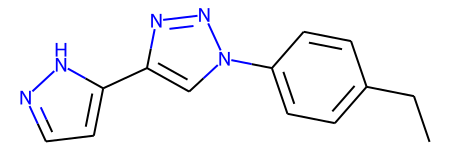

In [33]:
Chem.MolFromSmiles('CCc1ccc(N2C=C(c3ccn[nH]3)N=N2)cc1')

In [11]:
# boc_protected_amine = Chem.MolFromSmiles("CCN(CC)C(=S)[S-].CC[NH2+]CC")
# reaction = BocRemoval(bocamine=boc_protected_amine)
# reaction.get_product()

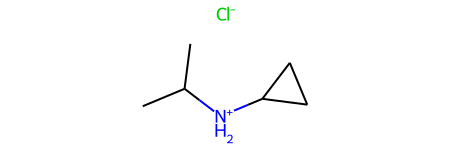

In [49]:
Chem.MolFromSmiles('CC(C)[NH2+]C1CC1.[Cl-]')

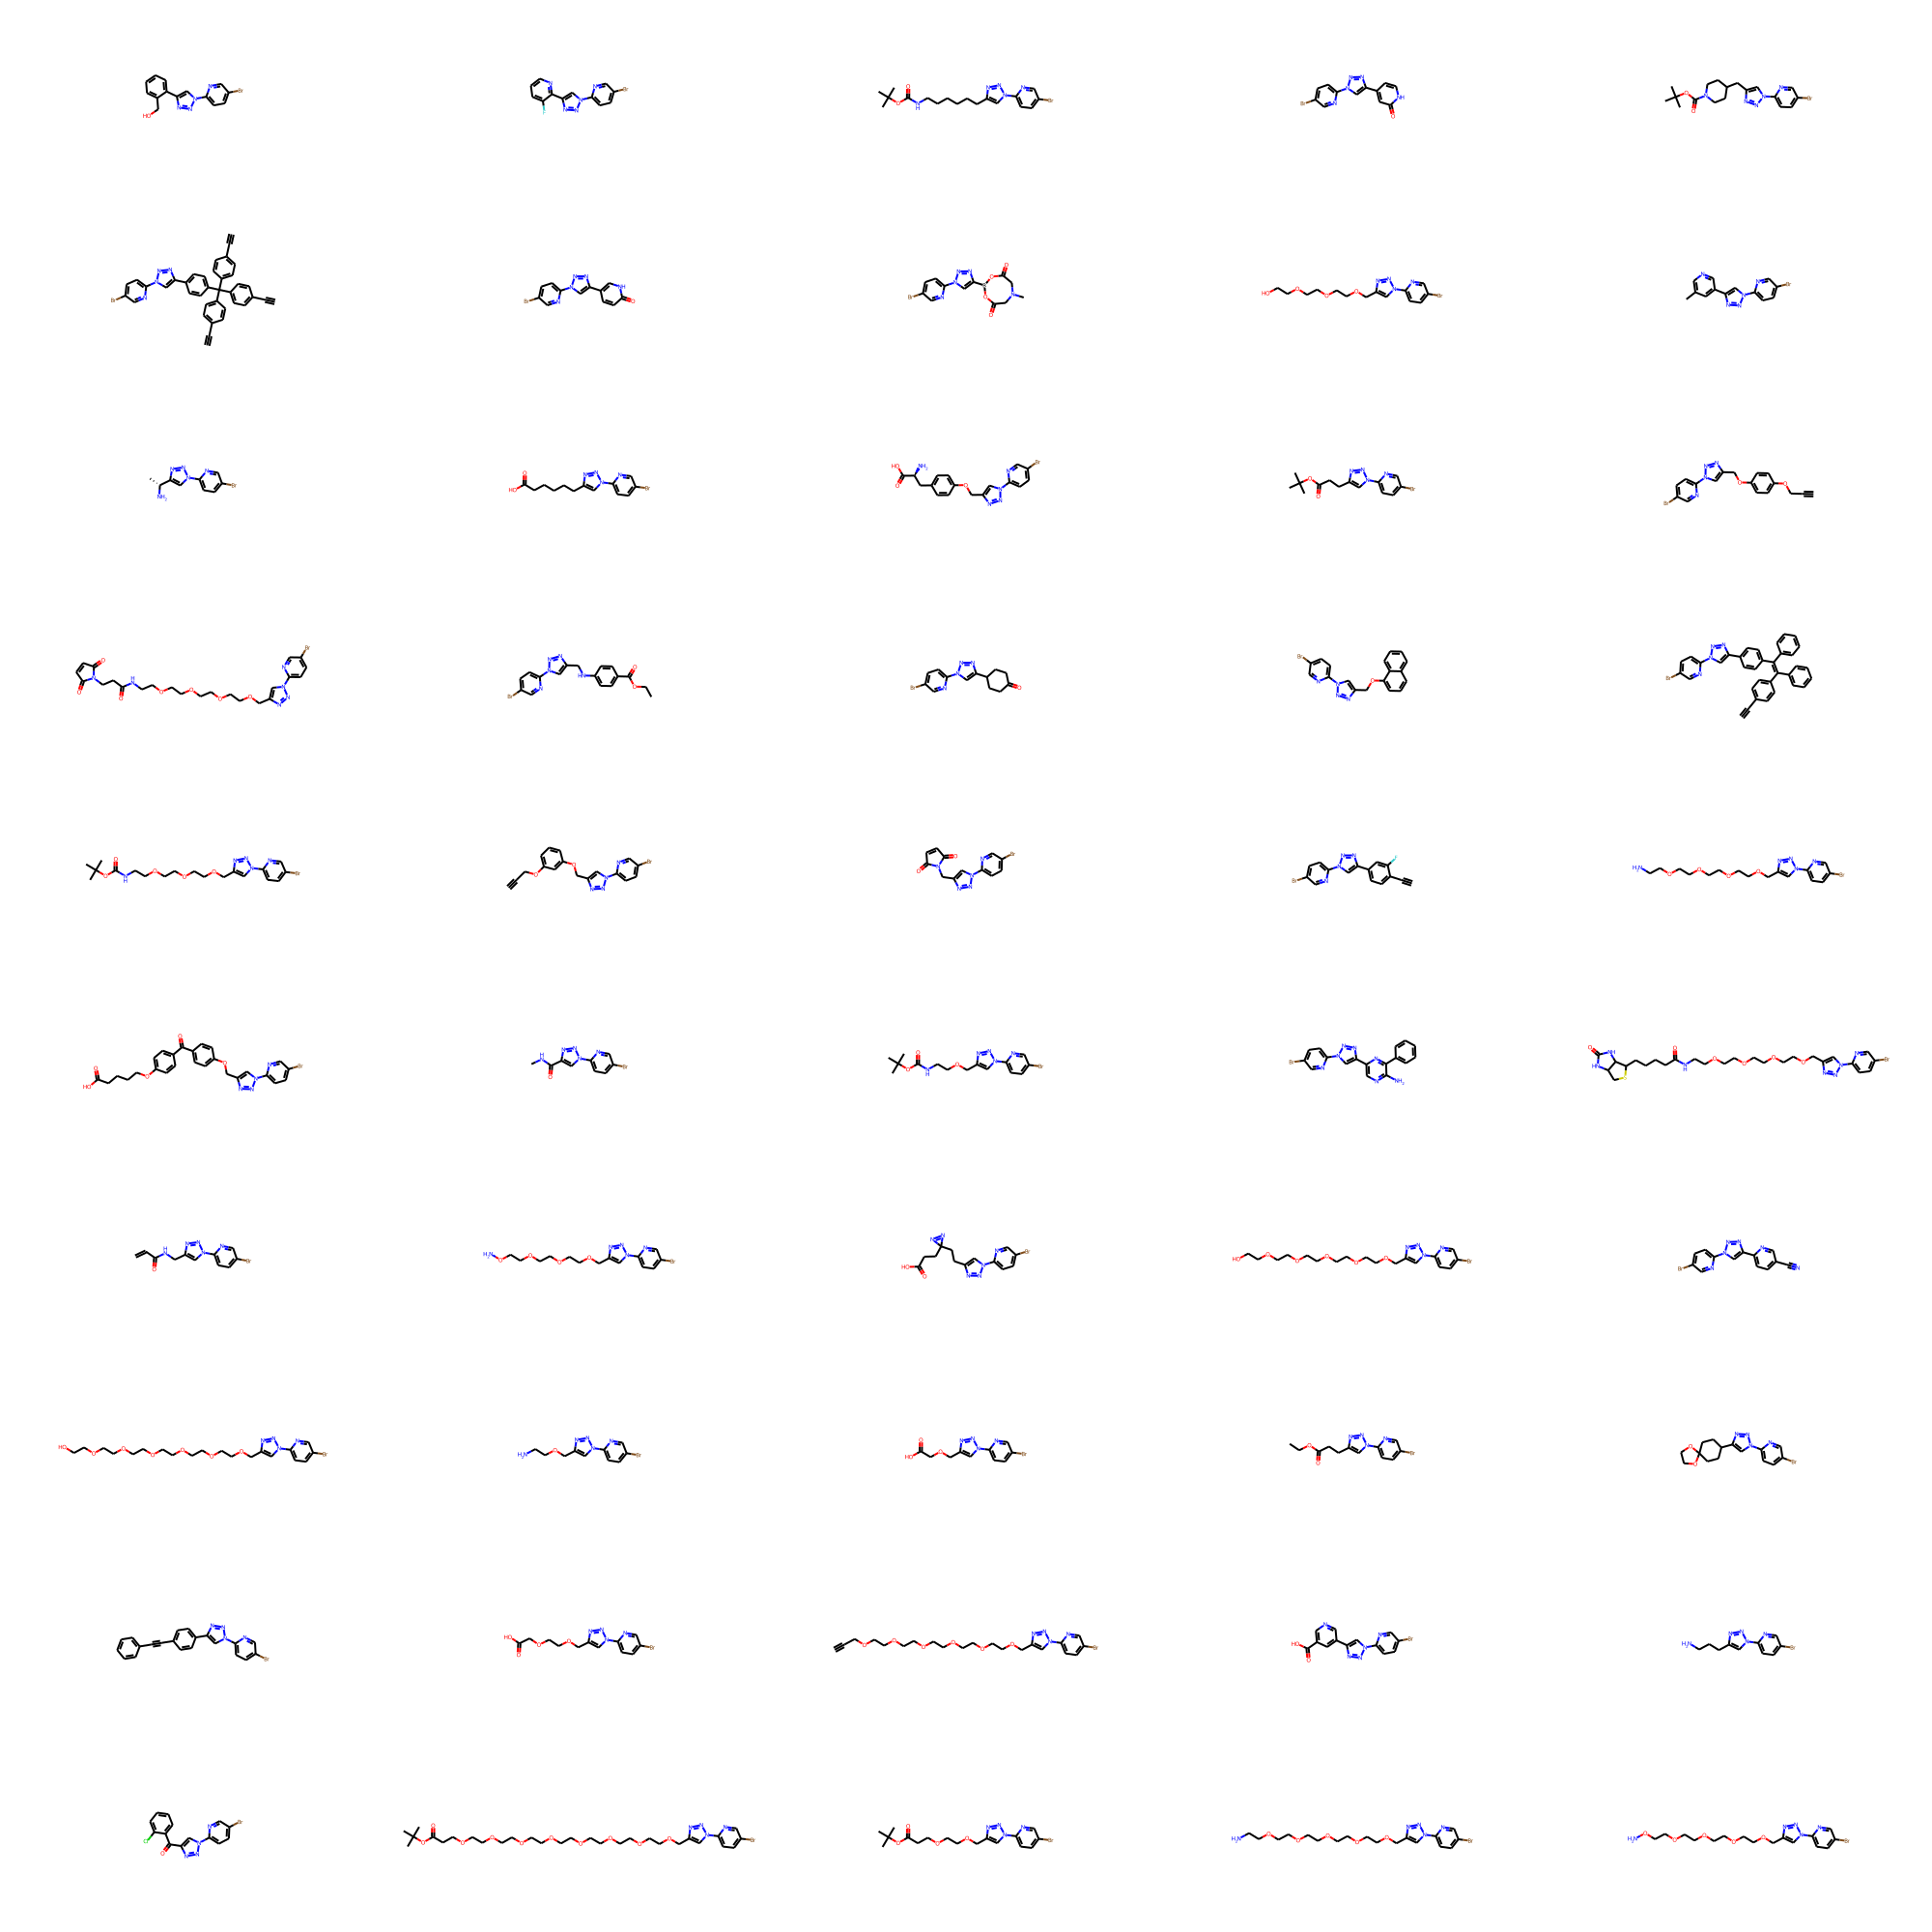

In [44]:
smiles_to_image_grid(triazole_smiles[41140:41240], img_size=(400, 200), mols_per_row=5, kekulize=True)


In [14]:
# rxn = Chem.ReactionFromSmarts('[*:6][C:1]#[C:2].[N-:3]=[N+:4]=[N:5]>>[N:5]1([C:2]=[C:1]([*:6])[N:3]=[N:4]1)')
# products = rxn.RunReactants( (Chem.MolFromSmiles('C#Cc1cccc(OC)c1'), Chem.MolFromSmiles('Cc1ccc(N[N]=[N+]=[N-])nn1')))
# Draw.MolToImage(products[0][0])
# a=Chem.MolToSmiles(products[0][0]).replace('[N+]=[N-]','N=N')
# Draw.MolToImage(Chem.MolFromSmiles(a))

In [15]:
# from rdkit import Chem

# def find_primary_amine_nitrogen(mol):
#     primary_amine_nitrogens = []
#     for atom in mol.GetAtoms():
#         if atom.GetSymbol() == "N" and atom.GetTotalNumHs() == 1:
#             primary_amine_nitrogens.append(atom.GetIdx())
#     return primary_amine_nitrogens

# amine_smiles = "Cl.Nc1c[nH]c2ccccc12" # 二甲胺的SMILES表示
# amine_mol = Chem.MolFromSmiles(amine_smiles)

# primary_amine_nitrogens = find_primary_amine_nitrogen(amine_mol)
# print("一级胺氮原子的索引：", primary_amine_nitrogens)
# 索引smiles中的一级胺氮原子


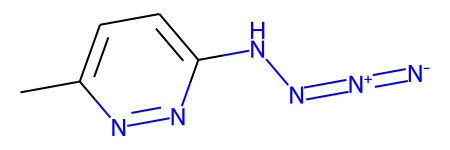

In [16]:
# # 示例
smiles_input = "Cc1ccc(NN)nn1"
a = convert_primary_amines_to_diazonium(smiles_input)
Chem.MolFromSmiles(convert_primary_amines_to_diazonium(smiles_input))


In [1]:
from ClickReaction import CuAAC

In [14]:
alkyne = Chem.MolFromSmiles("C#Cc1ccccc1C#C")
azide = Chem.MolFromSmiles("CCc1ccc([N]=[N+]=[N-])cc1")

reaction = CuAAC(alkyne=alkyne, azide=azide)
reaction.get_product()

AmbiguousProductError: Reaction <class 'ClickReaction.Reactions.CuAAC.CuAAC'> gave more than one product sets: ['C#Cc1ccccc1-c1cn(-c2ccc(CC)cc2)nn1', 'C#Cc1ccccc1-c1cn(-c2ccc(CC)cc2)nn1']